<a href="https://colab.research.google.com/github/smiledinisa/pytorch_learning/blob/master/AdversarialExampleGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You may be surprised to find that adding imperceptible perturbations（细微的扰动） 
# to an image can cause drastically different model performance

# 对抗攻击

In [1]:
import torch
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Categories of adversarial attacks

For context, there are many categories of adversarial attacks, each with a different goal and assumption of the attacker’s knowledge. However, in general the overarching goal is to add the least amount of **perturbation** to the input data to cause the **desired misclassification**. There are several kinds of assumptions of the attacker’s knowledge, two of which are: **white-box and black-box**. A white-box attack assumes the attacker has full knowledge and access to the model, including architecture, inputs, outputs, and weights. A black-box attack assumes the attacker only has access to the inputs and outputs of the model, and knows nothing about the underlying architecture or weights. There are also several types of goals, including **misclassification** and **source/target misclassification**. A goal of misclassification means the adversary only wants the output classification to be wrong but does not care what the new classification is. A source/target misclassification means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.


In this case, the **FGSM** attack is a **white-box** attack with the goal of **misclassification**. With this background information, we can now discuss the attack in detail.

### Fast Gradient Sign Attack

One of the first and most popular adversarial attacks to date is referred to as the Fast Gradient Sign Attack  [(FGSM)](https://arxiv.org/abs/1412.6572) and is described by Goodfellow et. al. in Explaining and Harnessing Adversarial Examples. The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, gradients. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

![替代文字](https://pytorch.org/tutorials/_images/fgsm_panda_image.png)


From the figure, x is the original input image correctly classified as a “panda”, y is the ground truth label for x, θ represents the model parameters, and J(θ,x,y) is the loss that is used to train the network. The attack backpropagates the gradient back to the input data to calculate ∇xJ(θ,x,y). Then, it adjusts the input data by a small step (ϵ or 0.007 in the picture) in the direction (i.e. sign(∇xJ(θ,x,y))) that will maximize the loss. The resulting perturbed image, x′, is then misclassified by the target network as a “gibbon” when it is still clearly a “panda”.

In [ ]:
# Threat Model

## Implementation
In this section, we will discuss the input parameters for the tutorial, define the model under attack, then code the attack and run some tests.

In [ ]:
# there are oly three inputs for this tutorial
# 1. epsilons 从0-1的序列，不应该超过1，表示扰动的大小。
# 2. pretrained_model. 下载预训练的模型。
# 3. use_cuda.


dataset: [here](https://github.com/pytorch/examples/tree/master/mnist)

pretrained model: [here](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing)

In [10]:
cd /content/drive/My Drive

/content/drive/My Drive


In [11]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = 'lenet_mnist_model.pth'
use_cuda = True

In [12]:
# Model Under Attack
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/content/sample_data/data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSM Attack

create perturbed_image:
***perturbed_image=image+epsilon∗sign(data_grad)
         =x+ϵ∗sign(∇xJ(θ,x,y))***


In [13]:
# FGSM attack code.

def fgsm_attack(image, epsilon, data_grad):
  sign_data_grad = data_grad.sign() #输入元素符号的新张量。
  perturbed_image = image + epsilon* sign_data_grad
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image



### Testing Function

In [15]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:  #注意batchsize=1

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


# 存储epsilon =0 和其他值，并且记录不同epsilon的测试准确率。

In [16]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


### Results
### Accuracy vs Epsilon


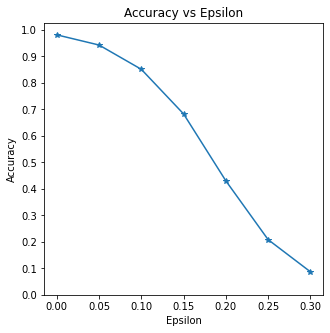

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

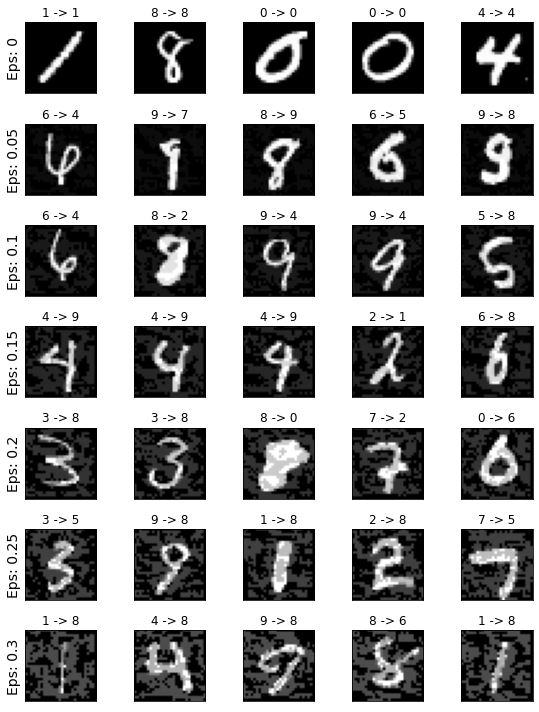

In [18]:
# Sample Adversarial Examples

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Hopefully this tutorial gives some insight into the topic of adversarial machine learning. There are many potential directions to go from here. This attack represents the very beginning of adversarial attack research and since there have been many subsequent ideas for how to attack and defend ML models from an adversary. In fact
at NIPS 2017 there was an adversarial attack and defense competition and many of the methods used in the competition are described in this paper:  [Adversarial Attacks and Defences Competition.](https://arxiv.org/pdf/1804.00097.pdf)

Another direction to go is adversarial attacks and defense in different domains. Adversarial research is not limited to the image domain, check out [this attack on speech-to-text models.](https://arxiv.org/pdf/1801.01944.pdf)  But perhaps the best way to learn more about adversarial machine learning is to get your hands dirty. Try to implement a different attack from the NIPS 2017 competition, and see how it differs from FGSM. Then, try to defend the model from your own attacks.

